# Temporal and spatial variation of Isoprene

### Katie Stevenson

# Introduction

Isoprene is the most abundant biogenic volatile organic compound. Emissions lead to secondary organic aerosol (SOA) formation, which have
significant impacts on climate, human health, and air quality. 

### Scientific questions:

- What are the temporal and spatial variation patterns of isoprene? (Have concentrations been increasing/decreasing over time? Are there seasonal variations? Where are these emissions most abundant/What are the sources?)
- How do these variations correlate to land use?

# Methods

### Datasets:

#### Isoprene data - 

- Satellite-derived isoprene emission estimates based on formaldehyde (HCHO) data from the Ozone Monitoring Instrument (OMI) between 2005-2014. HCHO data from De Smedt et al. (2015) and Isoprene estimates from the Royal Belgian Institute for Space Aeronomy (BIRA-IASB) 

#### Land use data - 

- HILDA+ (HIstoric Land Dynamics Assessment+) is a global dataset from high-resolution remote sensing of annual land use/cover change between 1960 and 2019. Data provided by the Committee on Earth Observation Satellites. 

In [4]:
# import necessary packages

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose, STL , MSTL
import matplotlib.colors as mcolors
from cartopy import crs as ccrs, feature as cfeature
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches 

In [2]:
# import 10 years of data (2005 - 2014)

urlretrieve("https://tropo.aeronomie.be/ProjectDir/ISOP/OMI/Top-down_C5H8_OMI_2005.nc", "Top-down_C5H8_OMI_2005.nc")
urlretrieve("https://tropo.aeronomie.be/ProjectDir/ISOP/OMI/Top-down_C5H8_OMI_2006.nc", "Top-down_C5H8_OMI_2006.nc")
urlretrieve("https://tropo.aeronomie.be/ProjectDir/ISOP/OMI/Top-down_C5H8_OMI_2007.nc", "Top-down_C5H8_OMI_2007.nc")
urlretrieve("https://tropo.aeronomie.be/ProjectDir/ISOP/OMI/Top-down_C5H8_OMI_2008.nc", "Top-down_C5H8_OMI_2008.nc")
urlretrieve("https://tropo.aeronomie.be/ProjectDir/ISOP/OMI/Top-down_C5H8_OMI_2009.nc", "Top-down_C5H8_OMI_2009.nc")
urlretrieve("https://tropo.aeronomie.be/ProjectDir/ISOP/OMI/Top-down_C5H8_OMI_2010.nc", "Top-down_C5H8_OMI_2010.nc")
urlretrieve("https://tropo.aeronomie.be/ProjectDir/ISOP/OMI/Top-down_C5H8_OMI_2011.nc", "Top-down_C5H8_OMI_2011.nc")
urlretrieve("https://tropo.aeronomie.be/ProjectDir/ISOP/OMI/Top-down_C5H8_OMI_2012.nc", "Top-down_C5H8_OMI_2012.nc")
urlretrieve("https://tropo.aeronomie.be/ProjectDir/ISOP/OMI/Top-down_C5H8_OMI_2013.nc", "Top-down_C5H8_OMI_2013.nc")
urlretrieve("https://tropo.aeronomie.be/ProjectDir/ISOP/OMI/Top-down_C5H8_OMI_2014.nc", "Top-down_C5H8_OMI_2014.nc");

In [5]:
# convert 10 files into datasets
# create concatenated dataset with data from all 10 years

ds_2005 = xr.open_dataset("Top-down_C5H8_OMI_2005.nc")
ds_2006 = xr.open_dataset("Top-down_C5H8_OMI_2006.nc")
ds_2007 = xr.open_dataset("Top-down_C5H8_OMI_2007.nc")
ds_2008 = xr.open_dataset("Top-down_C5H8_OMI_2008.nc")
ds_2009 = xr.open_dataset("Top-down_C5H8_OMI_2009.nc")
ds_2010 = xr.open_dataset("Top-down_C5H8_OMI_2010.nc")
ds_2011 = xr.open_dataset("Top-down_C5H8_OMI_2011.nc")
ds_2012 = xr.open_dataset("Top-down_C5H8_OMI_2012.nc")
ds_2013 = xr.open_dataset("Top-down_C5H8_OMI_2013.nc")
ds_2014 = xr.open_dataset("Top-down_C5H8_OMI_2014.nc")

ds = xr.concat([ds_2005, ds_2006, ds_2007, ds_2008, ds_2009, ds_2010, ds_2011, ds_2012, ds_2013, ds_2014], dim = "time")
ds

<xarray.Dataset> Size: 249MB
Dimensions:        (time: 120, lat: 360, lon: 720)
Coordinates:
  * lon            (lon) float32 3kB -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat            (lat) float32 1kB 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * time           (time) datetime64[ns] 960B 2005-01-01 ... 2014-12-01
Data variables:
    emis_cat_name  (time, lat) |S1 43kB b'B' b'i' b'o' b'g' ... b'' b'' b'' b''
    Grid_area      (time, lat, lon) float32 124MB 1.349e+07 ... 1.349e+07
    EMworldC5H8    (time, lat, lon) float32 124MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes: (12/26)
    Author:                        Jenny Stavrakou
    Institution:                   Belgian Institute for Space Aeronomy
    Comment:                       Top-down global monthly biogenic isoprene ...
    Start_Date:                    January 2005
    End_Date:                      December 2005
    Temporal_res:                  Monthly
    ...                            ...
    Grid_northb_unit:              degree
    Grid_lat_res:                  0.5
    Grid_lat_res_unit:             degree
    Grid_dlat:                     -0.5
    Grid_dlat_unit:                degree
    Grid_nlat:                     360

# Temporal Analysis 

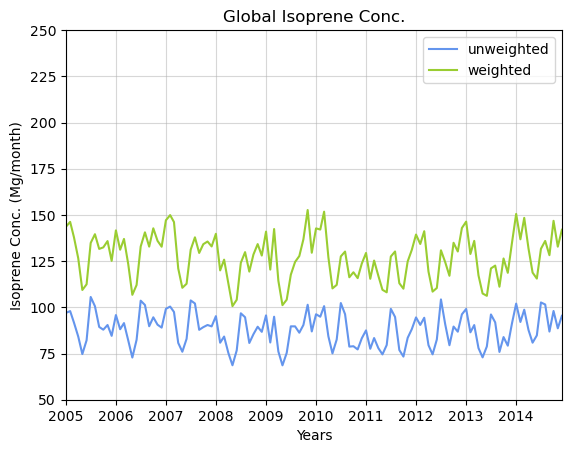

In [12]:
# compare weighted and unweighted time series 

weights = ds.Grid_area

global_mean = ds.EMworldC5H8.mean(dim = ('lon', 'lat'))
weighted_global_mean = ds.EMworldC5H8.weighted(weights).mean(dim = ('lon', 'lat'))

fig, axs = plt.subplots()
ax0 = axs

ax0.plot(global_mean.time, global_mean/1000, label = 'unweighted', color = 'cornflowerblue') # convert kg -> Mg
ax0.set_xlabel('Years')
ax0. set_ylabel('Isoprene Conc. (Mg/month)')
ax0.set_title('Global Isoprene Conc.')
ax0.set_xlim(global_mean.time[0], global_mean.time[-1])
ax0.set_ylim(50,250)
ax0.grid(alpha = 0.5)

ax0.plot(weighted_global_mean.time, weighted_global_mean/1000, label = 'weighted', color = 'yellowgreen')
ax0.legend();

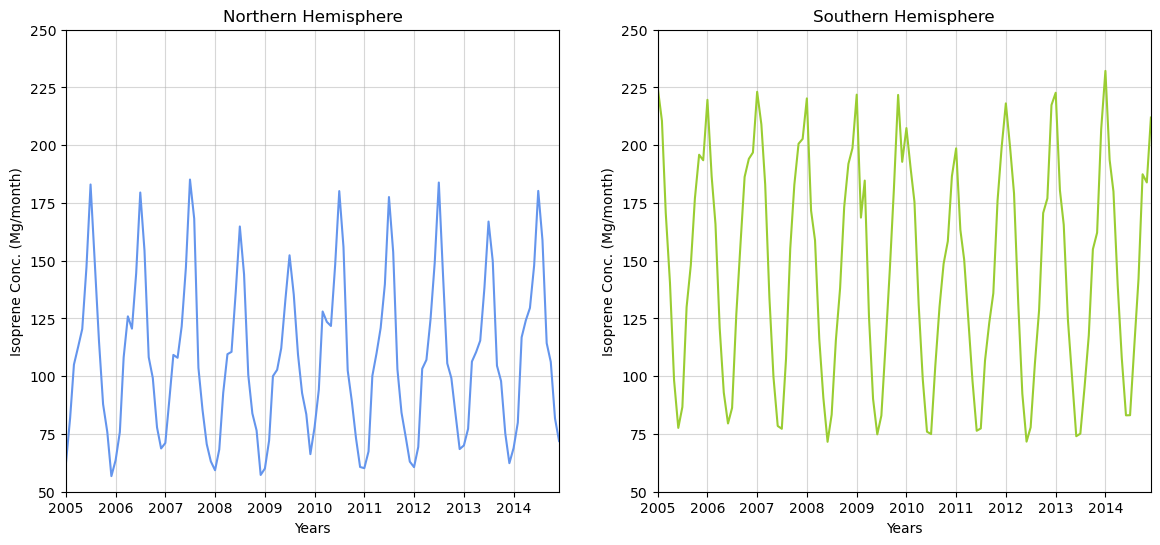

In [14]:
# mean concentration over time - northern vs southern hemispheres

NH = ds.sel(lat = slice(None, 0))
weights = NH.Grid_area
NH_mean = NH.EMworldC5H8.weighted(weights).mean(dim = ('lon', 'lat'))
# NH_mean = NH.EMworldC5H8.mean(dim = ['lat', 'lon']) # unweighted

SH = ds.sel(lat = slice(0, None)) 
weights = SH.Grid_area
SH_mean = SH.EMworldC5H8.weighted(weights).mean(dim = ('lon', 'lat'))
# SH_mean = SH.EMworldC5H8.mean(dim = ['lat', 'lon']) # unweighted

fig, axs = plt.subplots(1,2, figsize = (14,6))
ax0, ax1 = axs

ax0.plot(NH_mean.time, NH_mean/1000, color = 'cornflowerblue') # convert kg -> Mg (megagram)
ax0.set_xlabel('Years')
ax0. set_ylabel('Isoprene Conc. (Mg/month)')
ax0.set_title('Northern Hemisphere')
ax0.set_xlim(NH_mean.time[0], NH_mean.time[-1])
ax0.set_ylim(50,250)
ax0.grid(alpha = 0.5)

ax1.plot(SH_mean.time, SH_mean/1000, color = 'yellowgreen') # convert kg -> Mg (megagram)
ax1.set_xlabel('Years')
ax1. set_ylabel('Isoprene Conc. (Mg/month)')
ax1.set_title('Southern Hemisphere')
ax1.set_xlim(SH_mean.time[0], SH_mean.time[-1])
ax1.set_ylim(50,250)
ax1.grid(alpha = 0.5);

<xarray.DataArray 'EMworldC5H8' ()> Size: 4B
array(175360.6, dtype=float32)
Coordinates:
    month    int64 8B 7
<xarray.DataArray 'EMworldC5H8' ()> Size: 4B
array(218900.34, dtype=float32)
Coordinates:
    month    int64 8B 1


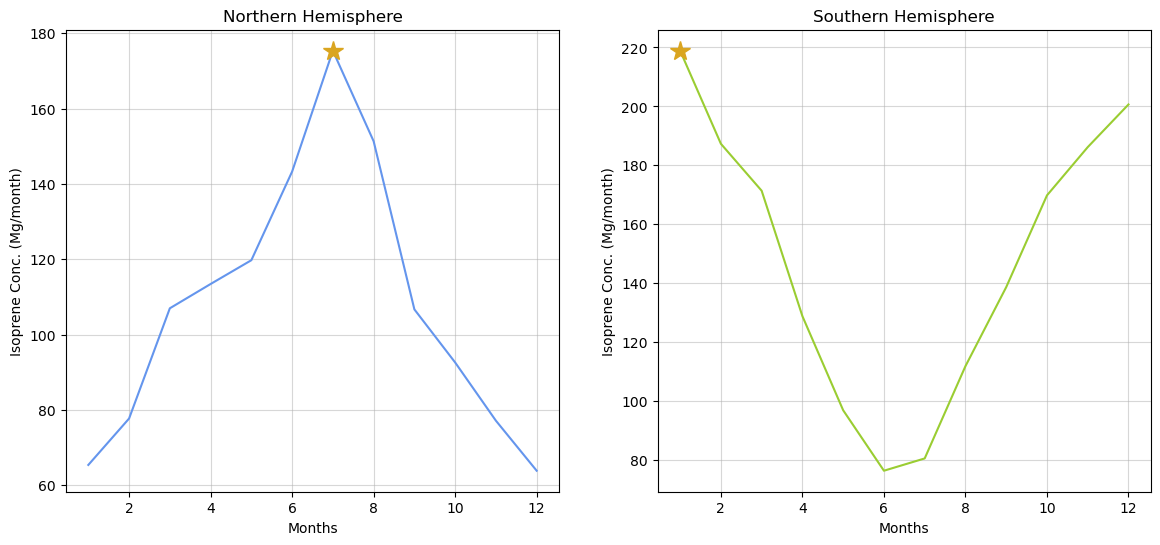

In [17]:
# monthly climatologies 

NH_gb = NH_mean.groupby('time.month') # monthly climatology of northern hemisphere (weighted)
NH_mm = NH_gb.mean(dim = 'time')

SH_gb = SH_mean.groupby('time.month') # monthly climatology of southern hemisphere (weighted)
SH_mm = SH_gb.mean(dim = 'time')

fig, axs = plt.subplots(1,2, figsize = (14,6))
ax0, ax1 = axs

ax0.plot(NH_mm.month, NH_mm/1000, color = 'cornflowerblue')
ax0.set_xlabel('Months')
ax0.set_ylabel('Isoprene Conc. (Mg/month)')
ax0.set_title('Northern Hemisphere')
print(max(NH_mm))
ax0.plot(7, 175.3606, marker = '*', markersize = 15, color = 'goldenrod')
ax0.grid(alpha = 0.5)

ax1.plot(SH_mm.month, SH_mm/1000, color = 'yellowgreen')
ax1.set_xlabel('Months')
ax1.set_ylabel('Isoprene Conc. (Mg/month)')
ax1.set_title('Southern Hemisphere')
print(max(SH_mm))
ax1.plot(1, 218.90034, marker = '*', markersize = 15, color = 'goldenrod')
ax1.grid(alpha = 0.5);

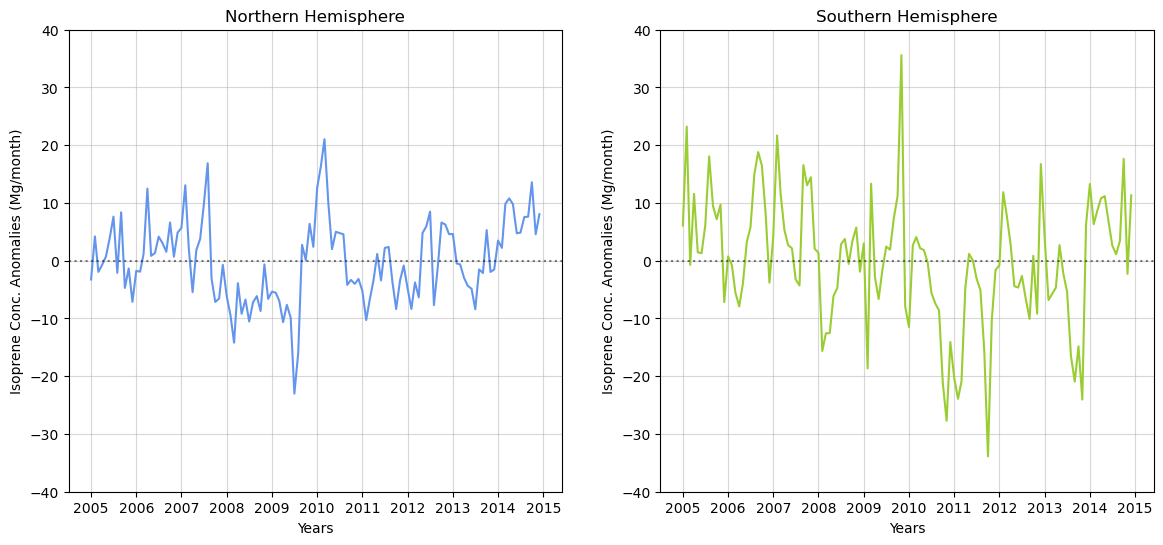

In [18]:
# temporal trends with seasonality removed (plotting anomalies in northern and southern hemispheres)

NH_gb = NH_mean.groupby('time.month')
NH_anom = NH_gb - NH_gb.mean(dim = 'time')

SH_gb = SH_mean.groupby('time.month')
SH_anom = SH_gb - SH_gb.mean(dim = 'time')

fig, axs = plt.subplots(1,2, figsize = (14,6))
ax0, ax1 = axs

ax0.plot(NH_anom.time, NH_anom/1000, color = 'cornflowerblue')
ax0.set_xlabel('Years')
ax0. set_ylabel('Isoprene Conc. Anomalies (Mg/month)')
ax0.set_title('Northern Hemisphere')
ax0.set_ylim(-40,40)
ax0.axhline(0, color = "k", linestyle = ':', alpha = 0.5)
ax0.grid(alpha = 0.5)

ax1.plot(SH_anom.time, SH_anom/1000, color = 'yellowgreen')
ax1.set_xlabel('Years')
ax1. set_ylabel('Isoprene Conc. Anomalies (Mg/month)')
ax1.set_title('Southern Hemisphere')
ax1.set_ylim(-40,40)
ax1.axhline(0, color = "k", linestyle = ':', alpha = 0.5)
ax1.grid(alpha = 0.5);

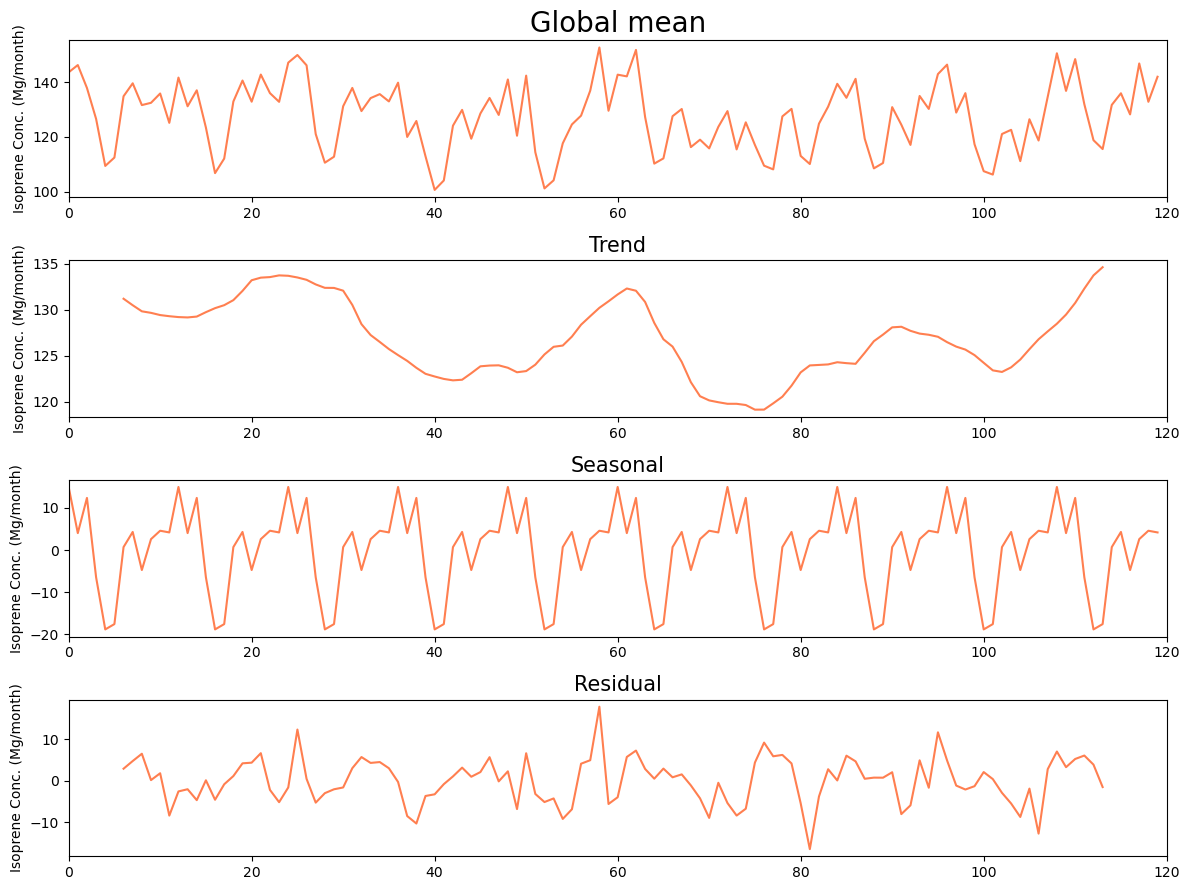

In [24]:
# decompose time series by trend, seasonal cycle, and residual

data = weighted_global_mean 

result = seasonal_decompose(data, period = 12, model = 'additive')

trend = result.trend
seasonal = result.seasonal
residual = result.resid

fig, ax = plt.subplots(4,1, figsize=(12,9))

ax[0].plot(data/1000, color = 'coral')
ax[0].set_title('Global mean', fontsize = 20)
ax[0].set_xlim(0,120)
ax[0].set_ylabel('Isoprene Conc. (Mg/month)')

ax[1].plot(trend/1000, color = 'coral')
ax[1].set_title('Trend', fontsize = 15)
ax[1].set_xlim(0,120)
ax[1].set_ylabel('Isoprene Conc. (Mg/month)')

ax[2].plot(seasonal/1000, color = 'coral')
ax[2].set_title('Seasonal', fontsize = 15)
ax[2].set_xlim(0,120)
ax[2].set_ylabel('Isoprene Conc. (Mg/month)')

ax[3].plot(residual/1000, color = 'coral')
ax[3].set_title('Residual', fontsize = 15)
ax[3].set_xlim(0,120)
ax[3].set_ylabel('Isoprene Conc. (Mg/month)')

plt.tight_layout()
plt.show();

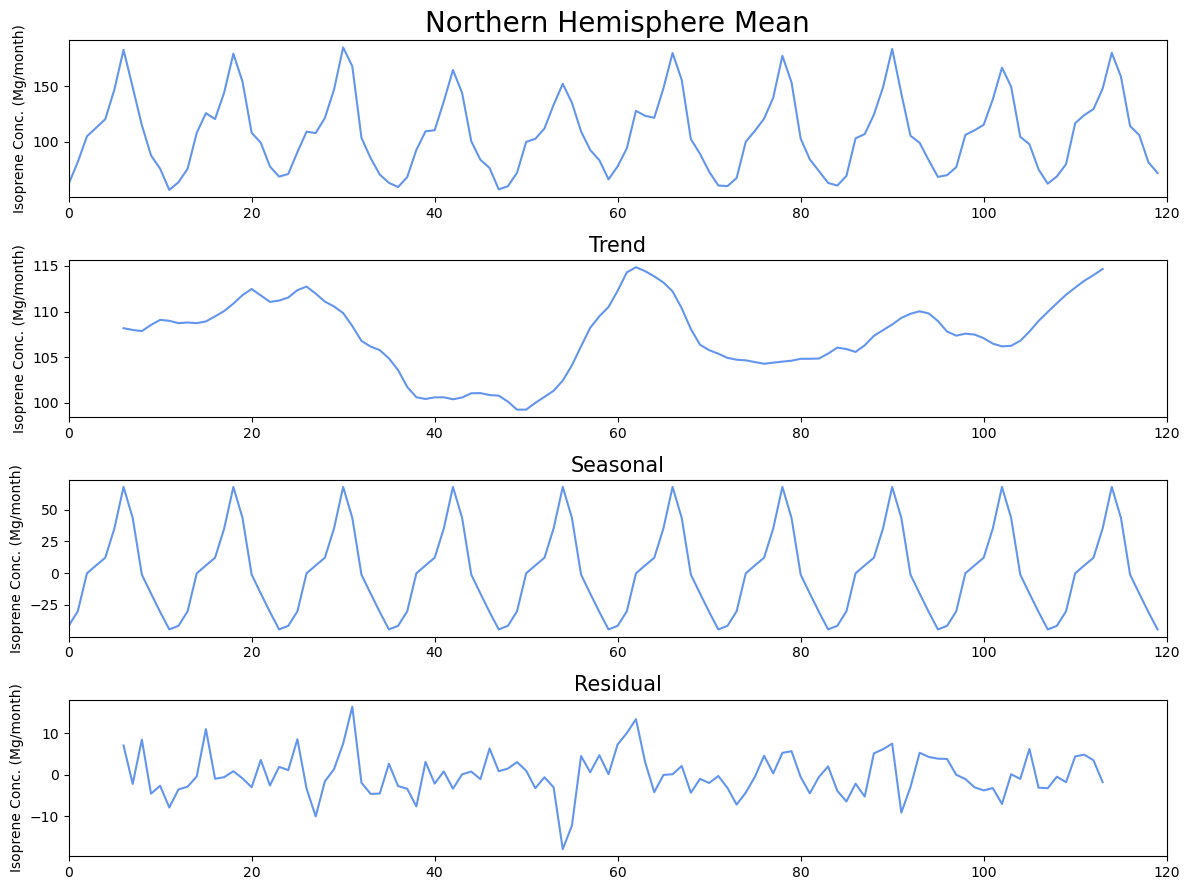

In [20]:
data = NH_mean 

result = seasonal_decompose(data, period = 12, model = 'additive')

trend = result.trend
seasonal = result.seasonal
residual = result.resid

fig, ax = plt.subplots(4, 1, figsize = (12,9))

ax[0].plot(data/1000, color = 'cornflowerblue')
ax[0].set_title('Northern Hemisphere Mean', fontsize = 20)
ax[0].set_xlim(0,120)
ax[0].set_ylabel('Isoprene Conc. (Mg/month)')

ax[1].plot(trend/1000, color = 'cornflowerblue')
ax[1].set_title('Trend', fontsize = 15)
ax[1].set_xlim(0,120)
ax[1].set_ylabel('Isoprene Conc. (Mg/month)')

ax[2].plot(seasonal/1000, color = 'cornflowerblue')
ax[2].set_title('Seasonal', fontsize = 15)
ax[2].set_xlim(0,120)
ax[2].set_ylabel('Isoprene Conc. (Mg/month)')

ax[3].plot(residual/1000, color = 'cornflowerblue')
ax[3].set_title('Residual', fontsize = 15)
ax[3].set_xlim(0,120)
ax[3].set_ylabel('Isoprene Conc. (Mg/month)')

plt.tight_layout()
plt.show();

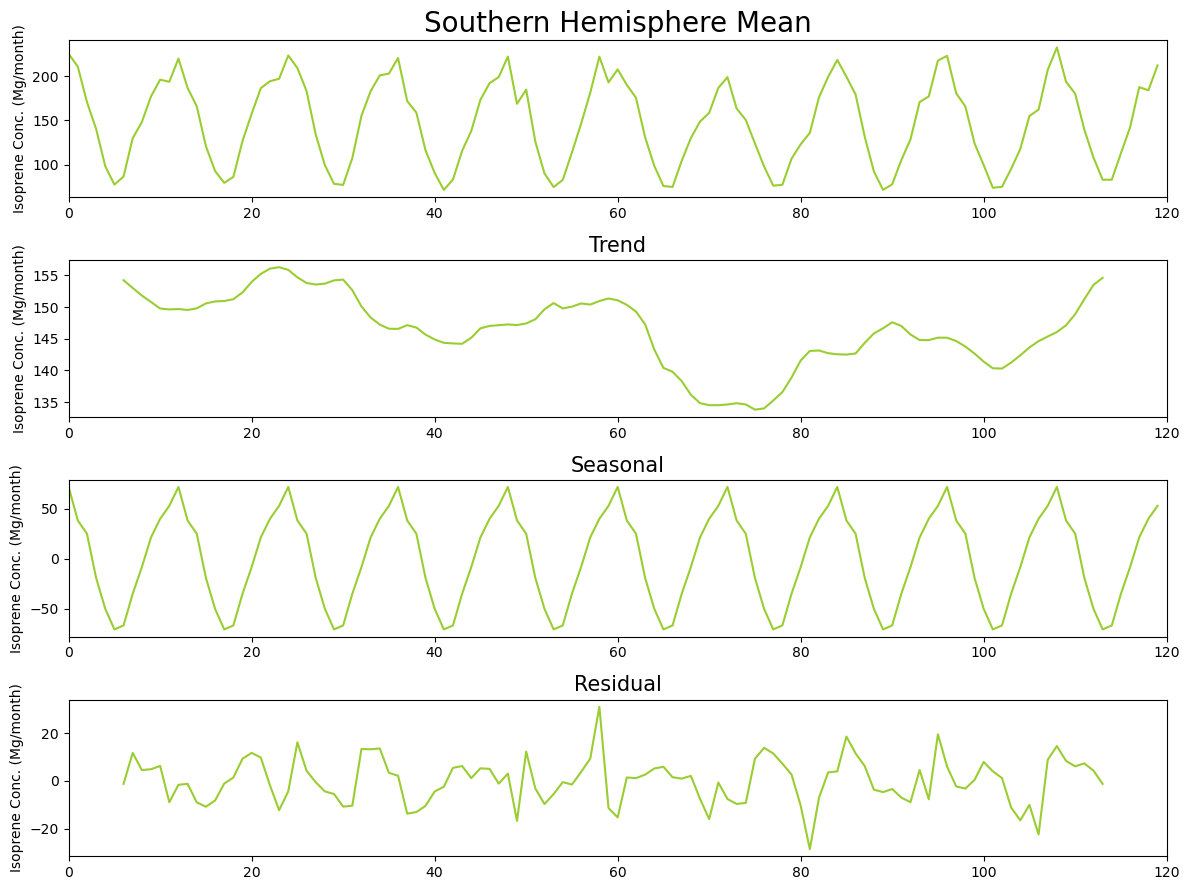

In [21]:
data = SH_mean 

result = seasonal_decompose(data, period = 12, model = 'additive')

trend = result.trend
seasonal = result.seasonal
residual = result.resid

fig, ax = plt.subplots(4, 1, figsize = (12,9))

ax[0].plot(data/1000, color = 'yellowgreen')
ax[0].set_title('Southern Hemisphere Mean', fontsize = 20)
ax[0].set_xlim(0,120)
ax[0].set_ylabel('Isoprene Conc. (Mg/month)')

ax[1].plot(trend/1000, color = 'yellowgreen')
ax[1].set_title('Trend', fontsize = 15)
ax[1].set_xlim(0,120)
ax[1].set_ylabel('Isoprene Conc. (Mg/month)')

ax[2].plot(seasonal/1000, color = 'yellowgreen')
ax[2].set_title('Seasonal', fontsize = 15)
ax[2].set_xlim(0,120)
ax[2].set_ylabel('Isoprene Conc. (Mg/month)')

ax[3].plot(residual/1000, color = 'yellowgreen')
ax[3].set_title('Residual', fontsize = 15)
ax[3].set_xlim(0,120)
ax[3].set_ylabel('Isoprene Conc. (Mg/month)')

plt.tight_layout()
plt.show();

# Spatial Analysis

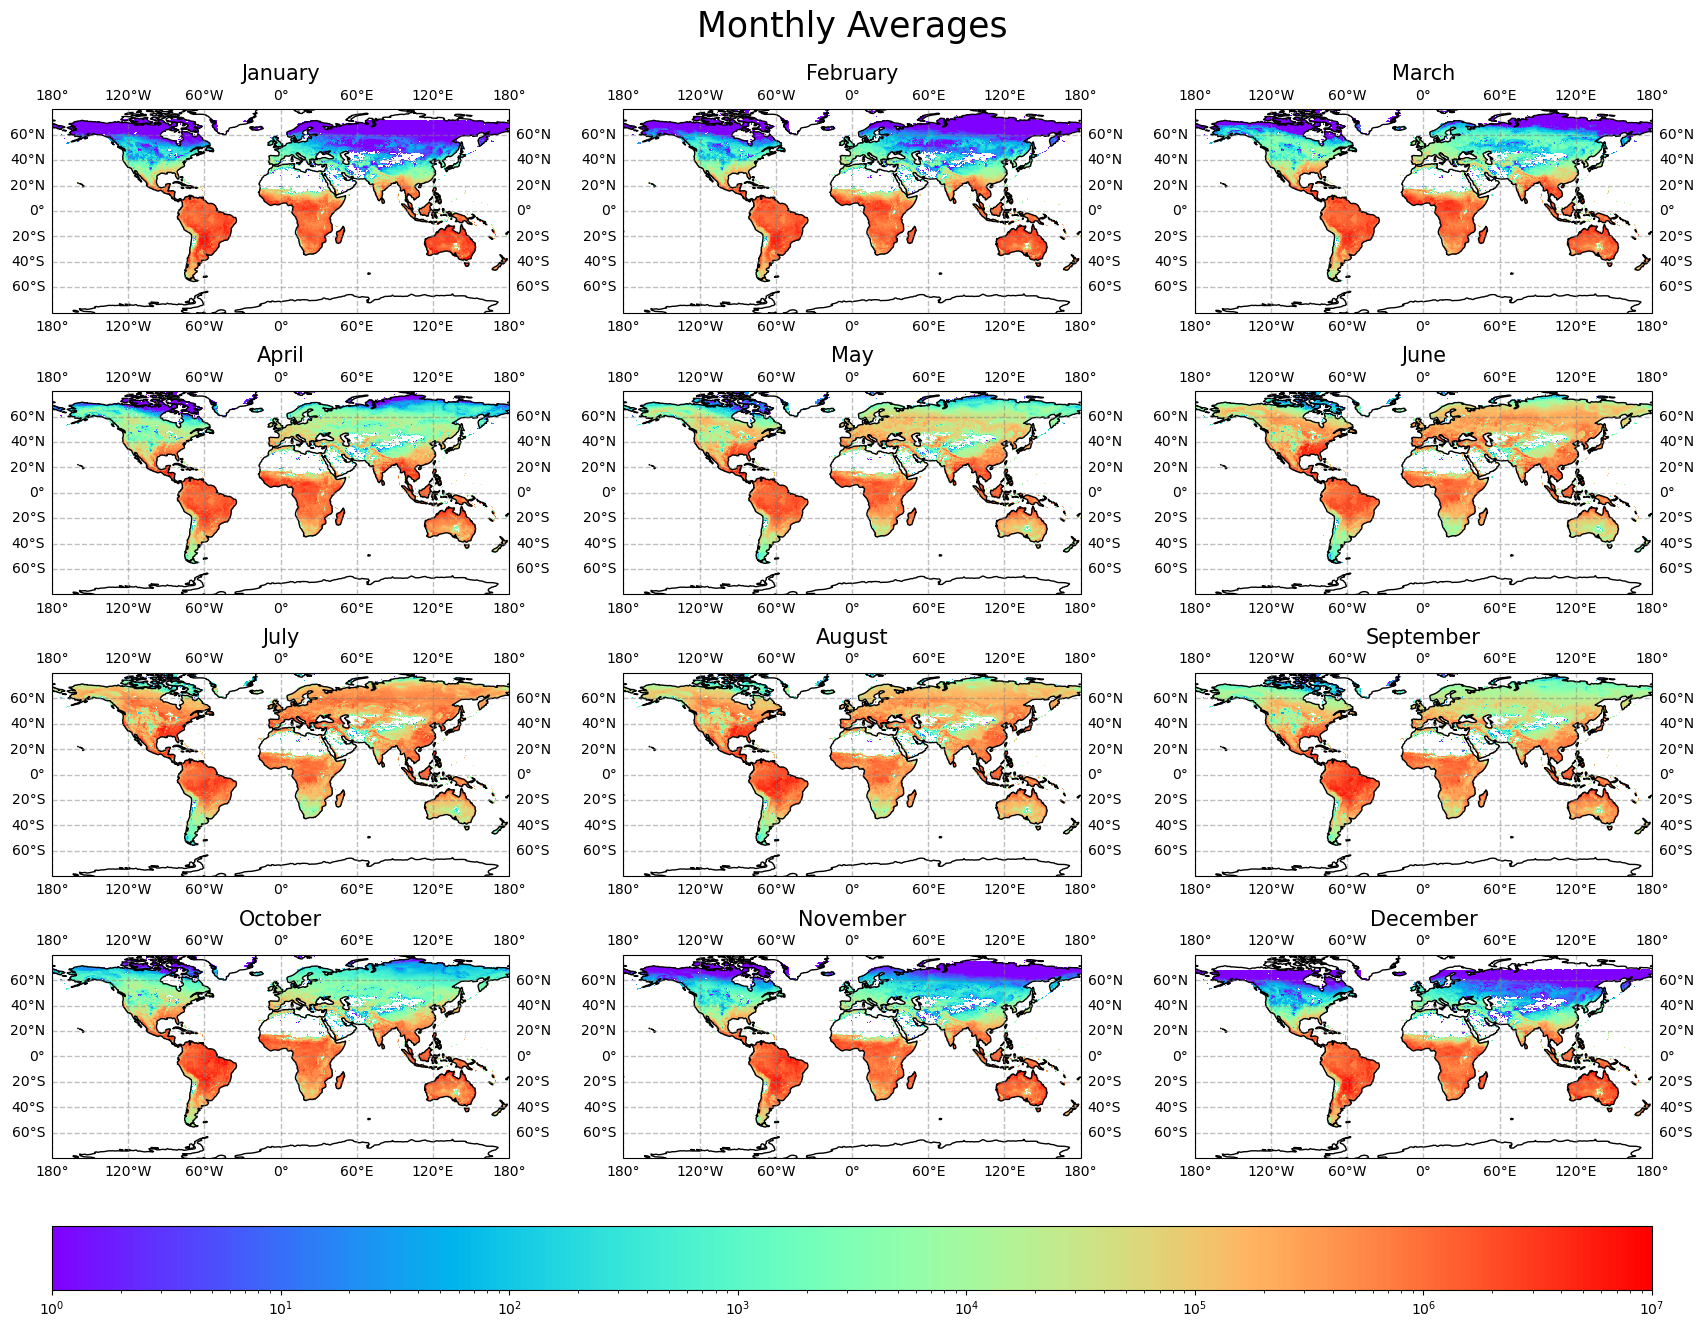

In [25]:
projPC = ccrs.PlateCarree()
lonW = -180
lonE = 180
latS = -80
latN = 80
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2
res = '110m'

# weights = ds.Grid_area
# ds_mean = ds.EMworldC5H8.weighted(weights).mean(dim = ('lon', 'lat'))

# ds_gb = ds_mean.groupby('time.month')
# ds_mm = ds_gb.mean(dim = 'time')

gb = ds.EMworldC5H8.groupby('time.month')
mm = gb.mean(dim = 'time')

cmap = plt.cm.rainbow
norm = mcolors.LogNorm(vmin=1, vmax=10000000)

fig, axs = plt.subplots(4,3, figsize = (20, 16), subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.subplots_adjust(bottom = 0.2, top = 0.98, left = 0.1, right = 0.9, wspace = 0.25, hspace = -0.3)

im = mm.isel(month = 0).plot(ax=axs[0,0], transform=ccrs.PlateCarree(), cmap = cmap, norm = norm, add_colorbar=False)
gl = axs[0,0].gridlines(draw_labels = True, linewidth = 1, color = 'gray', alpha = 0.5, linestyle = '--')
axs[0,0].set_extent([lonW, lonE, latS, latN], crs = projPC)
axs[0,0].coastlines(resolution = res, color = 'black')

mm.isel(month = 1).plot(ax=axs[0,1], transform=ccrs.PlateCarree(), cmap = cmap, norm = norm, add_colorbar=False)
gl = axs[0,1].gridlines(draw_labels = True, linewidth = 1, color = 'gray', alpha = 0.5, linestyle = '--')
axs[0,1].set_extent([lonW, lonE, latS, latN], crs = projPC)
axs[0,1].coastlines(resolution = res, color = 'black')

mm.isel(month = 2).plot(ax=axs[0,2], transform=ccrs.PlateCarree(), cmap = cmap, norm = norm, add_colorbar=False)
gl = axs[0,2].gridlines(draw_labels = True, linewidth = 1, color = 'gray', alpha = 0.5, linestyle = '--')
axs[0,2].set_extent([lonW, lonE, latS, latN], crs = projPC)
axs[0,2].coastlines(resolution = res, color = 'black');

mm.isel(month = 3).plot(ax=axs[1,0], transform=ccrs.PlateCarree(), cmap = cmap, norm = norm, add_colorbar=False)
gl = axs[1,0].gridlines(draw_labels = True, linewidth = 1, color = 'gray', alpha = 0.5, linestyle = '--')
axs[1,0].set_extent([lonW, lonE, latS, latN], crs = projPC)
axs[1,0].coastlines(resolution = res, color = 'black')

mm.isel(month = 4).plot(ax=axs[1,1], transform=ccrs.PlateCarree(), cmap = cmap, norm = norm, add_colorbar=False)
gl = axs[1,1].gridlines(draw_labels = True, linewidth = 1, color = 'gray', alpha = 0.5, linestyle = '--')
axs[1,1].set_extent([lonW, lonE, latS, latN], crs = projPC)
axs[1,1].coastlines(resolution = res, color = 'black')

mm.isel(month = 5).plot(ax=axs[1,2], transform=ccrs.PlateCarree(), cmap = cmap, norm = norm, add_colorbar=False)
gl = axs[1,2].gridlines(draw_labels = True, linewidth = 1, color = 'gray', alpha = 0.5, linestyle = '--')
axs[1,2].set_extent([lonW, lonE, latS, latN], crs = projPC)
axs[1,2].coastlines(resolution = res, color = 'black');

mm.isel(month = 6).plot(ax=axs[2,0], transform=ccrs.PlateCarree(), cmap = cmap, norm = norm, add_colorbar=False)
gl = axs[2,0].gridlines(draw_labels = True, linewidth = 1, color = 'gray', alpha = 0.5, linestyle = '--')
axs[2,0].set_extent([lonW, lonE, latS, latN], crs = projPC)
axs[2,0].coastlines(resolution = res, color = 'black')

mm.isel(month = 7).plot(ax=axs[2,1], transform=ccrs.PlateCarree(), cmap = cmap, norm = norm, add_colorbar=False)
gl = axs[2,1].gridlines(draw_labels = True, linewidth = 1, color = 'gray', alpha = 0.5, linestyle = '--')
axs[2,1].set_extent([lonW, lonE, latS, latN], crs = projPC)
axs[2,1].coastlines(resolution = res, color = 'black')

mm.isel(month = 8).plot(ax=axs[2,2], transform=ccrs.PlateCarree(), cmap = cmap, norm = norm, add_colorbar=False)
gl = axs[2,2].gridlines(draw_labels = True, linewidth = 1, color = 'gray', alpha = 0.5, linestyle = '--')
axs[2,2].set_extent([lonW, lonE, latS, latN], crs = projPC)
axs[2,2].coastlines(resolution = res, color = 'black');

mm.isel(month = 9).plot(ax=axs[3,0], transform=ccrs.PlateCarree(), cmap = cmap, norm = norm, add_colorbar=False)
gl = axs[3,0].gridlines(draw_labels = True, linewidth = 1, color = 'gray', alpha = 0.5, linestyle = '--')
axs[3,0].set_extent([lonW, lonE, latS, latN], crs = projPC)
axs[3,0].coastlines(resolution = res, color = 'black')

mm.isel(month = 10).plot(ax=axs[3,1], transform=ccrs.PlateCarree(), cmap = cmap, norm = norm, add_colorbar=False)
gl = axs[3,1].gridlines(draw_labels = True, linewidth = 1, color = 'gray', alpha = 0.5, linestyle = '--')
axs[3,1].set_extent([lonW, lonE, latS, latN], crs = projPC)
axs[3,1].coastlines(resolution = res, color = 'black')

mm.isel(month = 11).plot(ax=axs[3,2], transform=ccrs.PlateCarree(), cmap = cmap, norm = norm, add_colorbar=False)
gl = axs[3,2].gridlines(draw_labels = True, linewidth = 1, color = 'gray', alpha = 0.5, linestyle = '--')
axs[3,2].set_extent([lonW, lonE, latS, latN], crs = projPC)
axs[3,2].coastlines(resolution = res, color = 'black');

axs[0,0].set_title('January', fontsize = 15)
axs[0,1].set_title('February', fontsize = 15)
axs[0,2].set_title('March', fontsize = 15)
axs[1,0].set_title('April', fontsize = 15)
axs[1,1].set_title('May', fontsize = 15)
axs[1,2].set_title('June', fontsize = 15)
axs[2,0].set_title('July', fontsize = 15)
axs[2,1].set_title('August', fontsize = 15)
axs[2,2].set_title('September', fontsize = 15)
axs[3,0].set_title('October', fontsize = 15)
axs[3,1].set_title('November', fontsize = 15)
axs[3,2].set_title('December', fontsize = 15)
plt.suptitle('Monthly Averages', fontsize = 25)

#colorbar
cax = inset_axes(fig.axes[0], width = "80%", height = "4%", loc = 'lower center', bbox_to_anchor = (0, 0.18, 1, 1), bbox_transform = fig.transFigure, borderpad = 0)
cbar = fig.colorbar(im, cax = cax, orientation="horizontal");

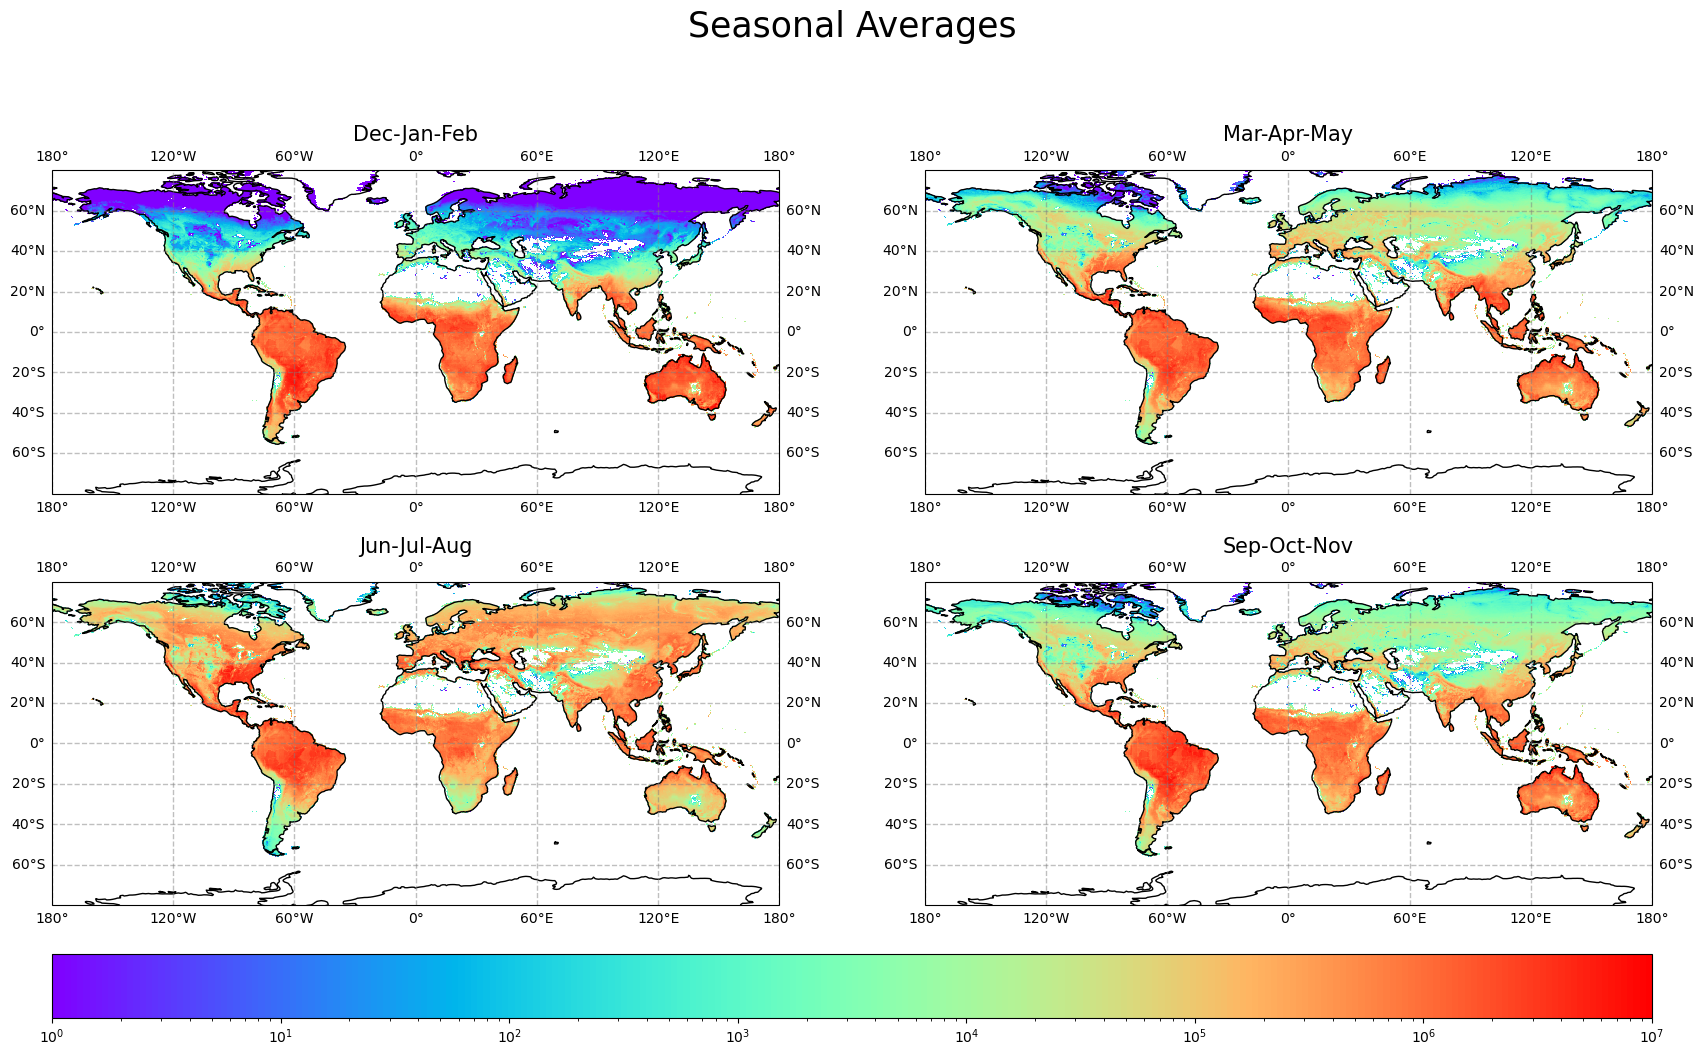

In [26]:
projPC = ccrs.PlateCarree()
lonW = -180
lonE = 180
latS = -80
latN = 80
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2
res = '110m'

gb = ds.EMworldC5H8.groupby('time.month')
mm = gb.mean(dim = 'time')

D_J_F = (mm.sel(month = [12,1,2]).mean(dim = 'month'))
M_A_M = (mm.sel(month = [3,4,5]).mean(dim = 'month'))
J_J_A = (mm.sel(month = [6,7,8]).mean(dim = 'month'))
S_O_N = (mm.sel(month = [9,10,11]).mean(dim = 'month'))

cmap = plt.cm.rainbow
norm = mcolors.LogNorm(vmin=1, vmax=10000000)

fig, axs = plt.subplots(2,2, figsize = (20, 16), subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.subplots_adjust(bottom = 0.2, top = 1.1, left = 0.1, right = 0.9, wspace = 0.2, hspace = -0.6)

im = D_J_F.plot(ax=axs[0,0], transform=ccrs.PlateCarree(), cmap = cmap, norm = norm, add_colorbar=False)
gl = axs[0,0].gridlines(draw_labels = True, linewidth = 1, color = 'gray', alpha = 0.5, linestyle = '--')
axs[0,0].set_extent([lonW, lonE, latS, latN], crs = projPC)
axs[0,0].coastlines(resolution = res, color = 'black')

M_A_M.plot(ax=axs[0,1], transform=ccrs.PlateCarree(), cmap = cmap, norm = norm, add_colorbar=False)
gl = axs[0,1].gridlines(draw_labels = True, linewidth = 1, color = 'gray', alpha = 0.5, linestyle = '--')
axs[0,1].set_extent([lonW, lonE, latS, latN], crs = projPC)
axs[0,1].coastlines(resolution = res, color = 'black')

J_J_A.plot(ax=axs[1,0], transform=ccrs.PlateCarree(), cmap = cmap, norm = norm, add_colorbar=False)
gl = axs[1,0].gridlines(draw_labels = True, linewidth = 1, color = 'gray', alpha = 0.5, linestyle = '--')
axs[1,0].set_extent([lonW, lonE, latS, latN], crs = projPC)
axs[1,0].coastlines(resolution = res, color = 'black');

S_O_N.plot(ax=axs[1,1], transform=ccrs.PlateCarree(), cmap = cmap, norm = norm, add_colorbar=False)
gl = axs[1,1].gridlines(draw_labels = True, linewidth = 1, color = 'gray', alpha = 0.5, linestyle = '--')
axs[1,1].set_extent([lonW, lonE, latS, latN], crs = projPC)
axs[1,1].coastlines(resolution = res, color = 'black')

axs[0,0].set_title('Dec-Jan-Feb', fontsize = 15)
axs[0,1].set_title('Mar-Apr-May', fontsize = 15)
axs[1,0].set_title('Jun-Jul-Aug', fontsize = 15)
axs[1,1].set_title('Sep-Oct-Nov', fontsize = 15)
plt.suptitle('Seasonal Averages', fontsize = 25)

#colorbar
cax = inset_axes(fig.axes[0], width = "80%", height = "4%", loc = 'lower center', bbox_to_anchor = (0, 0.35, 1, 1), bbox_transform = fig.transFigure, borderpad = 0)
cbar = fig.colorbar(im, cax = cax, orientation="horizontal");

In [27]:
# import land use data

lu = xr.open_dataset("2014landuse.nc")
lu

<xarray.Dataset> Size: 1MB
Dimensions:      (latitude: 360, longitude: 720)
Coordinates:
    time         float32 4B ...
  * latitude     (latitude) float64 3kB 89.75 89.25 88.75 ... -89.25 -89.75
  * longitude    (longitude) float64 6kB -179.8 -179.2 -178.8 ... 179.2 179.8
Data variables:
    LULC_states  (latitude, longitude) float32 1MB ...
Attributes:
    description:      HILDA+ land use/cover reconstruction - LULC states
    version:          GLOB-1.0-f
    info:             annual land cover/use maps 1899-2019
    temp_coverage:    1899-2019
    spat_coverage:    -180,-90: 180,90
    temp_resolution:  annual
    spat_resolution:  0.01 degree
    projection:       EPSG:4326 - WGS 84 – Geographic
    producer:         Winkler, Karina (WUR/KIT)

In [28]:
# simplify the numeric codes for each of the land use types

lu['LULC_states'] = lu['LULC_states'].where(lu['LULC_states'] != 11, other = 1)
lu['LULC_states'] = lu['LULC_states'].where(lu['LULC_states'] != 22, other = 2)
lu['LULC_states'] = lu['LULC_states'].where(lu['LULC_states'] != 33, other = 3)
lu['LULC_states'] = lu['LULC_states'].where(lu['LULC_states'] != 40, other = 4)
lu['LULC_states'] = lu['LULC_states'].where(lu['LULC_states'] != 41, other = 4)
lu['LULC_states'] = lu['LULC_states'].where(lu['LULC_states'] != 42, other = 4)
lu['LULC_states'] = lu['LULC_states'].where(lu['LULC_states'] != 43, other = 4)
lu['LULC_states'] = lu['LULC_states'].where(lu['LULC_states'] != 44, other = 4)
lu['LULC_states'] = lu['LULC_states'].where(lu['LULC_states'] != 45, other = 4)
lu['LULC_states'] = lu['LULC_states'].where(lu['LULC_states'] != 55, other = 5)
lu['LULC_states'] = lu['LULC_states'].where(lu['LULC_states'] != 66, other = 6)
lu['LULC_states'] = lu['LULC_states'].where(lu['LULC_states'] != 77, other = 7)

unique_values = np.unique(lu.LULC_states)
print(unique_values)

[ 0.  1.  2.  3.  4.  5.  6.  7. nan]


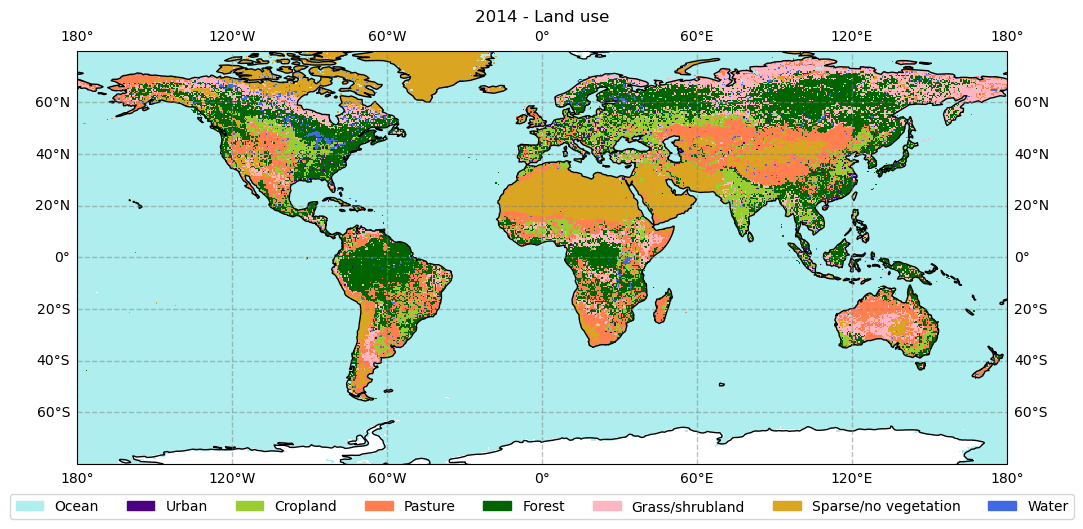

In [29]:
# Numeric code: 0 ocean, 1 urban, 2 cropland, 3 pasture/rangeland, 4 forest, 5 unmanaged grass/shrubland, 6 sparse/no vegetation, 7 water

projPC = ccrs.PlateCarree()
lonW = -180
lonE = 180
latS = -80
latN = 80
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2
res = '110m'

colors = ['paleturquoise', 'indigo', 'yellowgreen', 'coral', 'darkgreen', 'lightpink', 'goldenrod', 'royalblue']
cmap = mcolors.ListedColormap(colors)

fig, ax0 = plt.subplots(figsize = (12,8), subplot_kw=dict(projection=ccrs.PlateCarree()))

lu.LULC_states.plot(ax = ax0, cmap = cmap, add_colorbar = False, transform=ccrs.PlateCarree())
gl = ax0.gridlines(draw_labels = True, linewidth = 1, color = 'gray', alpha = 0.5, linestyle = '--')
ax0.set_extent([lonW, lonE, latS, latN], crs = projPC)
ax0.coastlines(resolution = res, color = 'black')
ax0.set_title('2014 - Land use')
ax0.set_ylabel('Latitude')
ax0.set_xlabel('Longitude')

legend_handles = [
    mpatches.Patch(color='paleturquoise'),
    mpatches.Patch(color='indigo'),
    mpatches.Patch(color='yellowgreen'),
    mpatches.Patch(color='coral'),
    mpatches.Patch(color='darkgreen'),
    mpatches.Patch(color='lightpink'),
    mpatches.Patch(color='goldenrod'),
    mpatches.Patch(color='royalblue')]

ax0.legend(handles = legend_handles, labels = ['Ocean', 'Urban', 'Cropland', 'Pasture', 'Forest', 'Grass/shrubland', 'Sparse/no vegetation', 'Water'], 
           loc = 'lower center', bbox_to_anchor=(0, -0.15, 1, 1), ncol = 8);


In [30]:
# create masks for the land use types

land_use = ['ocean', 'urban', 'cropland', 'pasture', 'forest', 'grass_shrubland', 'sparse_novegetation', 'water']

for i, land in enumerate(land_use):
    globals()[land + '_mask'] = lu.LULC_states == i

In [31]:
land_use = ['ocean', 'urban', 'cropland', 'pasture', 'forest', 'grass_shrubland', 'sparse_novegetation', 'water']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec']

          
for i, month in enumerate(months):
    globals()[month + '_sums'] = []
    for i2, land in enumerate(land_use):
        globals()[land + '_conc_' + month] = mm.isel(month = [i]).where(globals()[land + '_mask'].values)
        globals()[land + '_sum_' + month] = globals()[land + '_conc_' + month].sum(dim = ('lon', 'lat')).values
        globals()[month + '_sums'].append(globals()[land + '_sum_' + month])
    globals()['total_conc_' + month] = sum(globals()[month + '_sums'])

    globals()['percents_' + month] = []
    for i3, land in enumerate(land_use):
        globals()[land + '_percent_' + month] = ( globals()[month + '_sums'][i3] ) / ( globals()['total_conc_' + month] )
        globals()['percents_' + month].append(globals()[land + '_percent_' + month].tolist()[0])
    globals()['percents_' + month] = np.array(globals()['percents_' + month])

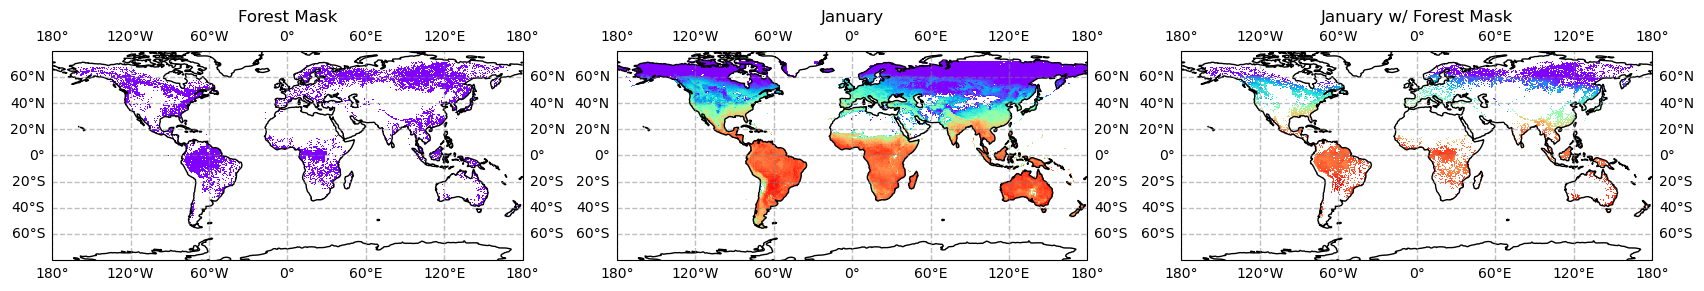

In [32]:
cmap = plt.cm.rainbow
norm = mcolors.LogNorm(vmin=1, vmax=10000000)

fig, axs = plt.subplots(1,3, figsize = (20, 18), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax0, ax1, ax2 = axs
fig.subplots_adjust(bottom = 0.2, top = 1.1, left = 0.1, right = 0.9, wspace = 0.2, hspace = -0.6)

forest_mask.plot(ax=ax0, transform=ccrs.PlateCarree(), cmap = cmap, norm = norm, add_colorbar=False)
gl = ax0.gridlines(draw_labels = True, linewidth = 1, color = 'gray', alpha = 0.5, linestyle = '--')
ax0.set_extent([lonW, lonE, latS, latN], crs = projPC)
ax0.coastlines(resolution = res, color = 'black')
ax0.set_title('Forest Mask')

mm.isel(month = 0).plot(ax=ax1, transform=ccrs.PlateCarree(), cmap = cmap, norm = norm, add_colorbar=False)
gl = ax1.gridlines(draw_labels = True, linewidth = 1, color = 'gray', alpha = 0.5, linestyle = '--')
ax1.set_extent([lonW, lonE, latS, latN], crs = projPC)
ax1.coastlines(resolution = res, color = 'black')
ax1.set_title('January')

forest_conc_Jan.plot(ax=ax2, transform=ccrs.PlateCarree(), cmap = cmap, norm = norm, add_colorbar=False)
gl = ax2.gridlines(draw_labels = True, linewidth = 1, color = 'gray', alpha = 0.5, linestyle = '--')
ax2.set_extent([lonW, lonE, latS, latN], crs = projPC)
ax2.coastlines(resolution = res, color = 'black')
ax2.set_title('January w/ Forest Mask');

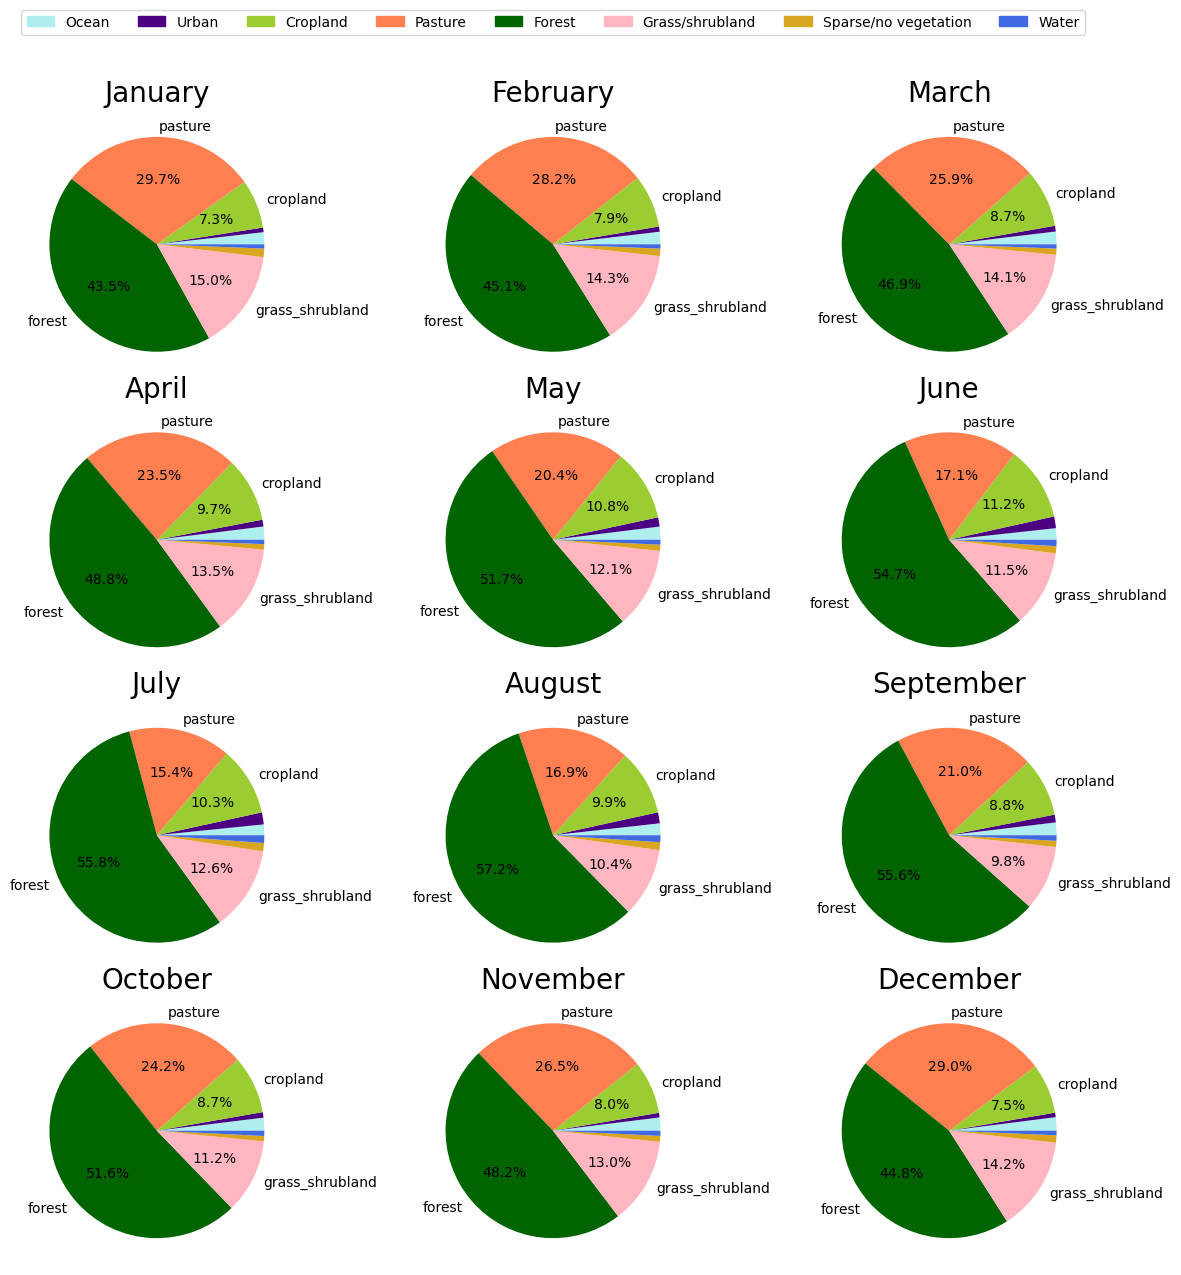

In [33]:
colors = ['paleturquoise', 'indigo', 'yellowgreen', 'coral', 'darkgreen', 'lightpink', 'goldenrod', 'royalblue']
months1 = ['Jan', 'Feb', 'Mar']
months2 = ['Apr', 'May', 'Jun']
months3 = ['Jul','Aug','Sep']
months4 = ['Oct','Nov','Dec']

fig, axs = plt.subplots(4, 3, figsize=(15, 15))
fig.subplots_adjust(wspace = 0.07, hspace = 0.1)

for i, month in enumerate(months1):
    globals()['wedges' + str(i)], globals()['texts' + str(i)], globals()['autotexts' + str(i)] = axs[0,i].pie(globals()['percents_' + month], labels = land_use, autopct='%1.1f%%', colors = colors)
    threshold = 5
    for label, pct_label in zip(globals()['texts' + str(i)], globals()['autotexts' + str(i)]):
        pct_value = pct_label.get_text().rstrip('%')
        if float(pct_value) < threshold:
            label.set_text('')
            pct_label.set_text('')

for i, month in enumerate(months2):
    globals()['wedges' + str(i)], globals()['texts' + str(i)], globals()['autotexts' + str(i)] = axs[1,i].pie(globals()['percents_' + month], labels = land_use, autopct='%1.1f%%', colors = colors)
    threshold = 5
    for label, pct_label in zip(globals()['texts' + str(i)], globals()['autotexts' + str(i)]):
        pct_value = pct_label.get_text().rstrip('%')
        if float(pct_value) < threshold:
            label.set_text('')
            pct_label.set_text('')

for i, month in enumerate(months3):
    globals()['wedges' + str(i)], globals()['texts' + str(i)], globals()['autotexts' + str(i)] = axs[2,i].pie(globals()['percents_' + month], labels = land_use, autopct='%1.1f%%', colors = colors)
    threshold = 5
    for label, pct_label in zip(globals()['texts' + str(i)], globals()['autotexts' + str(i)]):
        pct_value = pct_label.get_text().rstrip('%')
        if float(pct_value) < threshold:
            label.set_text('')
            pct_label.set_text('')

for i, month in enumerate(months4):
    globals()['wedges' + str(i)], globals()['texts' + str(i)], globals()['autotexts' + str(i)] = axs[3,i].pie(globals()['percents_' + month], labels = land_use, autopct='%1.1f%%', colors = colors)
    threshold = 5
    for label, pct_label in zip(globals()['texts' + str(i)], globals()['autotexts' + str(i)]):
        pct_value = pct_label.get_text().rstrip('%')
        if float(pct_value) < threshold:
            label.set_text('')
            pct_label.set_text('')

axs[0,0].set_title('January', fontsize = 20), axs[0,1].set_title('February', fontsize = 20), axs[0,2].set_title('March', fontsize = 20)
axs[1,0].set_title('April', fontsize = 20), axs[1,1].set_title('May', fontsize = 20), axs[1,2].set_title('June', fontsize = 20)
axs[2,0].set_title('July', fontsize = 20), axs[2,1].set_title('August', fontsize = 20), axs[2,2].set_title('September', fontsize = 20)
axs[3,0].set_title('October', fontsize = 20), axs[3,1].set_title('November', fontsize = 20), axs[3,2].set_title('December', fontsize = 20)

legend_handles = [
    mpatches.Patch(color='paleturquoise'),
    mpatches.Patch(color='indigo'),
    mpatches.Patch(color='yellowgreen'),
    mpatches.Patch(color='coral'),
    mpatches.Patch(color='darkgreen'),
    mpatches.Patch(color='lightpink'),
    mpatches.Patch(color='goldenrod'),
    mpatches.Patch(color='royalblue')]

axs[0,1].legend(handles = legend_handles, labels = ['Ocean', 'Urban', 'Cropland', 'Pasture', 'Forest', 'Grass/shrubland', 'Sparse/no vegetation', 'Water'], 
           loc = 'upper center', bbox_to_anchor = (0, 0.4, 1, 1), ncol = 8);

In [40]:
# import land use data - forests!

lu_forest = xr.open_dataset("2014landuse.nc")
lu_forest

<xarray.Dataset> Size: 1MB
Dimensions:      (latitude: 360, longitude: 720)
Coordinates:
    time         float32 4B ...
  * latitude     (latitude) float64 3kB 89.75 89.25 88.75 ... -89.25 -89.75
  * longitude    (longitude) float64 6kB -179.8 -179.2 -178.8 ... 179.2 179.8
Data variables:
    LULC_states  (latitude, longitude) float32 1MB ...
Attributes:
    description:      HILDA+ land use/cover reconstruction - LULC states
    version:          GLOB-1.0-f
    info:             annual land cover/use maps 1899-2019
    temp_coverage:    1899-2019
    spat_coverage:    -180,-90: 180,90
    temp_resolution:  annual
    spat_resolution:  0.01 degree
    projection:       EPSG:4326 - WGS 84 – Geographic
    producer:         Winkler, Karina (WUR/KIT)

In [41]:
# simplify the numeric codes for each of the land use types - forests!

lu_forest['LULC_states'] = lu_forest['LULC_states'].where(lu_forest['LULC_states'] != 00, other = np.nan)
lu_forest['LULC_states'] = lu_forest['LULC_states'].where(lu_forest['LULC_states'] != 11, other = np.nan)
lu_forest['LULC_states'] = lu_forest['LULC_states'].where(lu_forest['LULC_states'] != 22, other = np.nan)
lu_forest['LULC_states'] = lu_forest['LULC_states'].where(lu_forest['LULC_states'] != 33, other = np.nan)
lu_forest['LULC_states'] = lu_forest['LULC_states'].where(lu_forest['LULC_states'] != 40, other = 0)
lu_forest['LULC_states'] = lu_forest['LULC_states'].where(lu_forest['LULC_states'] != 41, other = 1)
lu_forest['LULC_states'] = lu_forest['LULC_states'].where(lu_forest['LULC_states'] != 42, other = 2)
lu_forest['LULC_states'] = lu_forest['LULC_states'].where(lu_forest['LULC_states'] != 43, other = 3)
lu_forest['LULC_states'] = lu_forest['LULC_states'].where(lu_forest['LULC_states'] != 44, other = 4)
lu_forest['LULC_states'] = lu_forest['LULC_states'].where(lu_forest['LULC_states'] != 45, other = 5)
lu_forest['LULC_states'] = lu_forest['LULC_states'].where(lu_forest['LULC_states'] != 55, other = np.nan)
lu_forest['LULC_states'] = lu_forest['LULC_states'].where(lu_forest['LULC_states'] != 66, other = np.nan)
lu_forest['LULC_states'] = lu_forest['LULC_states'].where(lu_forest['LULC_states'] != 77, other = np.nan)

unique_values = np.unique(lu_forest.LULC_states)
print(unique_values)

[ 0.  1.  2.  3.  4.  5. nan]


In [42]:
# create masks for the land use types - forest!

land_use = ['Other', 'Evergreen_needle_leaf','Evergreen_broad_leaf','Deciduous_needle_leaf','Deciduous_broad_leaf', 'Mixed']

for i, land in enumerate(land_use):
    globals()[land + '_mask'] = lu_forest.LULC_states == i

In [43]:
land_use = ['Other', 'Evergreen_needle_leaf','Evergreen_broad_leaf','Deciduous_needle_leaf','Deciduous_broad_leaf', 'Mixed']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec']

          
for i, month in enumerate(months):
    globals()[month + '_sums'] = []
    for i2, land in enumerate(land_use):
        globals()[land + '_conc_' + month] = mm.isel(month = [i]).where(globals()[land + '_mask'].values)
        globals()[land + '_sum_' + month] = globals()[land + '_conc_' + month].sum(dim = ('lon', 'lat')).values
        globals()[month + '_sums'].append(globals()[land + '_sum_' + month])
    globals()['total_conc_' + month] = sum(globals()[month + '_sums'])

    globals()['percents_' + month] = []
    for i3, land in enumerate(land_use):
        globals()[land + '_percent_' + month] = ( globals()[month + '_sums'][i3] ) / ( globals()['total_conc_' + month] )
        globals()['percents_' + month].append(globals()[land + '_percent_' + month].tolist()[0])
    globals()['percents_' + month] = np.array(globals()['percents_' + month])

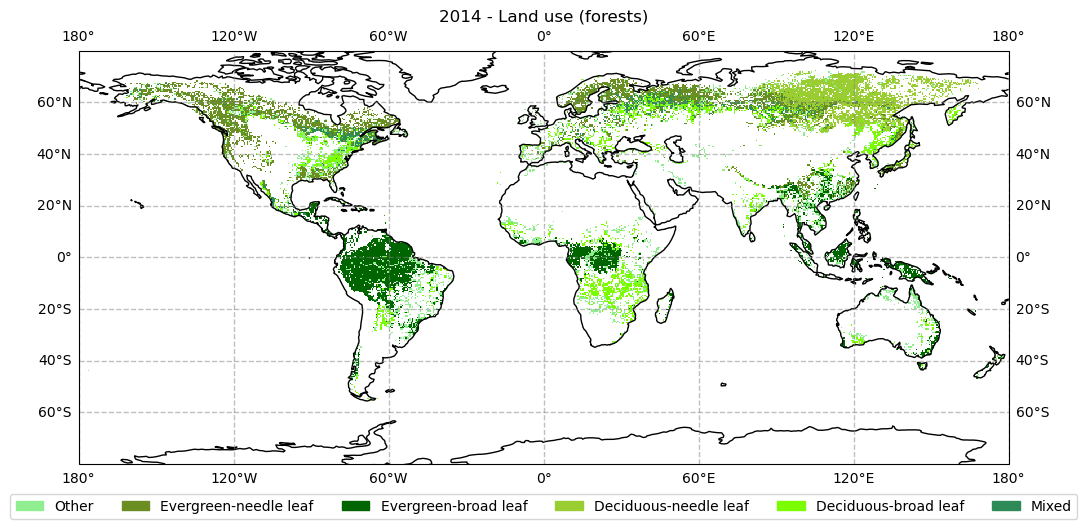

In [49]:
# Numeric code: 0 Unknown/Other, 1 Evergreen - needle leaf, 2 Evergreen - broad leaf, 3 Deciduous - needle leaf, 4 Deciduous - broad leaf, 5 Mixed

projPC = ccrs.PlateCarree()
lonW = -180
lonE = 180
latS = -80
latN = 80
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2
res = '110m'

# colors = ['paleturquoise', 'indigo', 'yellowgreen', 'coral', 'darkgreen', 'lightpink']
colors = ['lightgreen', 'olivedrab', 'darkgreen', 'yellowgreen', 'lawngreen', 'seagreen']
cmap = mcolors.ListedColormap(colors)

fig, ax0 = plt.subplots(figsize = (12,8), subplot_kw=dict(projection=ccrs.PlateCarree()))

lu_forest.LULC_states.plot(ax = ax0, cmap = cmap, add_colorbar = False, transform=ccrs.PlateCarree())
gl = ax0.gridlines(draw_labels = True, linewidth = 1, color = 'gray', alpha = 0.5, linestyle = '--')
ax0.set_extent([lonW, lonE, latS, latN], crs = projPC)
ax0.coastlines(resolution = res, color = 'black')
ax0.set_title('2014 - Land use (forests)')
ax0.set_ylabel('Latitude')
ax0.set_xlabel('Longitude')

legend_handles = [
    mpatches.Patch(color='lightgreen'),
    mpatches.Patch(color='olivedrab'),
    mpatches.Patch(color='darkgreen'),
    mpatches.Patch(color='yellowgreen'),
    mpatches.Patch(color='lawngreen'),
    mpatches.Patch(color='seagreen')]

ax0.legend(handles = legend_handles, labels = ['Other', 'Evergreen-needle leaf','Evergreen-broad leaf','Deciduous-needle leaf','Deciduous-broad leaf', 'Mixed'], 
           loc = 'lower center', bbox_to_anchor=(0, -0.15, 1, 1), ncol = 6);

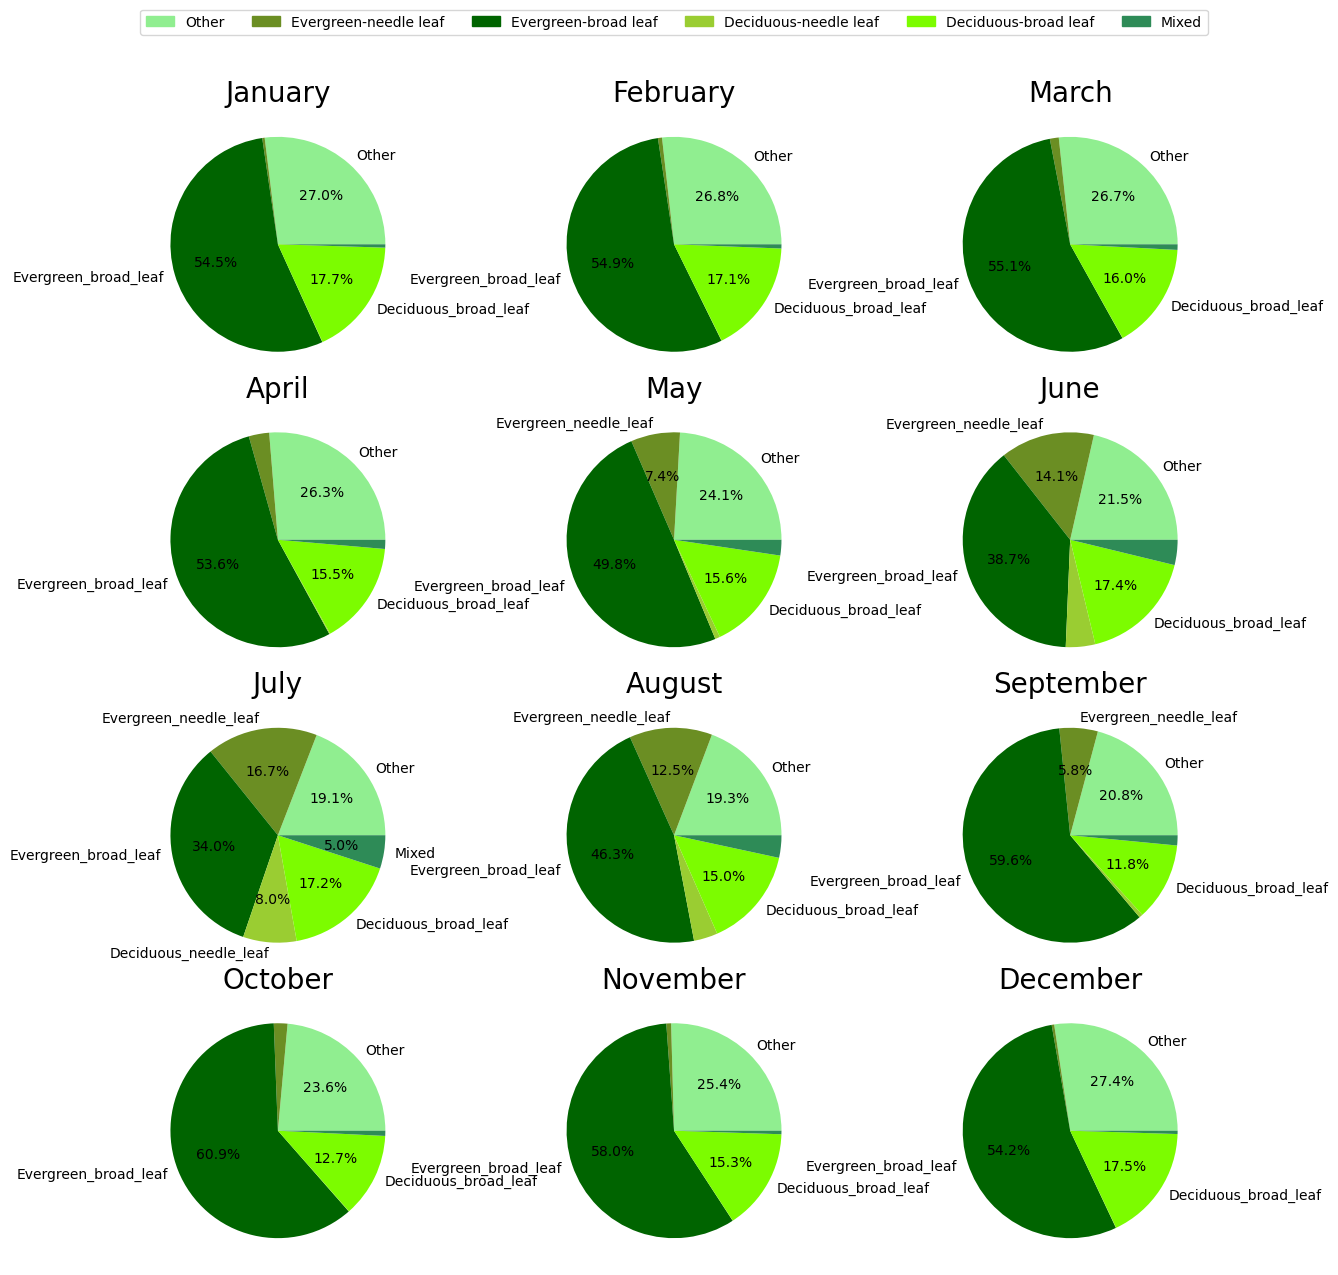

In [50]:
colors = ['lightgreen', 'olivedrab', 'darkgreen', 'yellowgreen', 'lawngreen', 'seagreen']
months1 = ['Jan', 'Feb', 'Mar']
months2 = ['Apr', 'May', 'Jun']
months3 = ['Jul','Aug','Sep']
months4 = ['Oct','Nov','Dec']

fig, axs = plt.subplots(4, 3, figsize=(15, 15))
fig.subplots_adjust(wspace = 0.07, hspace = 0.1)

for i, month in enumerate(months1):
    globals()['wedges' + str(i)], globals()['texts' + str(i)], globals()['autotexts' + str(i)] = axs[0,i].pie(globals()['percents_' + month], labels = land_use, autopct='%1.1f%%', colors = colors)
    threshold = 5
    for label, pct_label in zip(globals()['texts' + str(i)], globals()['autotexts' + str(i)]):
        pct_value = pct_label.get_text().rstrip('%')
        if float(pct_value) < threshold:
            label.set_text('')
            pct_label.set_text('')

for i, month in enumerate(months2):
    globals()['wedges' + str(i)], globals()['texts' + str(i)], globals()['autotexts' + str(i)] = axs[1,i].pie(globals()['percents_' + month], labels = land_use, autopct='%1.1f%%', colors = colors)
    threshold = 5
    for label, pct_label in zip(globals()['texts' + str(i)], globals()['autotexts' + str(i)]):
        pct_value = pct_label.get_text().rstrip('%')
        if float(pct_value) < threshold:
            label.set_text('')
            pct_label.set_text('')
            
for i, month in enumerate(months3):
    globals()['wedges' + str(i)], globals()['texts' + str(i)], globals()['autotexts' + str(i)] = axs[2,i].pie(globals()['percents_' + month], labels = land_use, autopct='%1.1f%%', colors = colors)
    threshold = 5
    for label, pct_label in zip(globals()['texts' + str(i)], globals()['autotexts' + str(i)]):
        pct_value = pct_label.get_text().rstrip('%')
        if float(pct_value) < threshold:
            label.set_text('')
            pct_label.set_text('')

for i, month in enumerate(months4):
    globals()['wedges' + str(i)], globals()['texts' + str(i)], globals()['autotexts' + str(i)] = axs[3,i].pie(globals()['percents_' + month], labels = land_use, autopct='%1.1f%%', colors = colors)
    threshold = 5
    for label, pct_label in zip(globals()['texts' + str(i)], globals()['autotexts' + str(i)]):
        pct_value = pct_label.get_text().rstrip('%')
        if float(pct_value) < threshold:
            label.set_text('')
            pct_label.set_text('')

axs[0,0].set_title('January', fontsize = 20), axs[0,1].set_title('February', fontsize = 20), axs[0,2].set_title('March', fontsize = 20)
axs[1,0].set_title('April', fontsize = 20), axs[1,1].set_title('May', fontsize = 20), axs[1,2].set_title('June', fontsize = 20)
axs[2,0].set_title('July', fontsize = 20), axs[2,1].set_title('August', fontsize = 20), axs[2,2].set_title('September', fontsize = 20)
axs[3,0].set_title('October', fontsize = 20), axs[3,1].set_title('November', fontsize = 20), axs[3,2].set_title('December', fontsize = 20)

legend_handles = [
    mpatches.Patch(color='lightgreen'),
    mpatches.Patch(color='olivedrab'),
    mpatches.Patch(color='darkgreen'),
    mpatches.Patch(color='yellowgreen'),
    mpatches.Patch(color='lawngreen'),
    mpatches.Patch(color='seagreen')]

axs[0,1].legend(handles = legend_handles, labels = ['Other', 'Evergreen-needle leaf','Evergreen-broad leaf','Deciduous-needle leaf','Deciduous-broad leaf', 'Mixed'], 
           loc = 'upper center', bbox_to_anchor = (0, 0.4, 1, 1), ncol = 6);

# Results

#### Temporal
- A seasonal phase shift is present between the northern and southern hemispheres
- No apparent increasing/decreasing trend throughout these years

#### Spatial
- During Dec-Jan-Feb season, northern hemisphere is at it's lowest isoprene emission, while the southern hemisphere is at it's highest

#### Land use correlation
- Forest land use accounted for the majority of isoprene emissions for every month, with pastures being the second highest isoprene emitters
- Evergreen - broad leaf forests were the highest forest-emitters of isoprene for every month

# Discussion

Isoprene emission throughout 2005-2014 did not show any obious long-term trends. The seasonal cycles for the northern and southern hemisphere were out of phase with each other, with the southern hemisphere's isoprene concentrations reaching much higher quantities. The landuse type that emitted the highest percentage of isoprene was forests. Within that category, broad leaf Evergreen forest emitted the most. This information has implications for the production of SOA and tropospheric pollutants. I think that incorporating temperature and relative humidity data into this assessment would potentially be beneficial and provide more information to investigate the global differences in isoprene emissions.